In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/DATASET/archive.zip -d data/

Archive:  /content/drive/MyDrive/DATASET/archive.zip
  inflating: data/label_class_dict.csv  
  inflating: data/metadata.csv       
  inflating: data/png/test/22828930_15.png  
  inflating: data/png/test/22828990_15.png  
  inflating: data/png/test/22829050_15.png  
  inflating: data/png/test/23429020_15.png  
  inflating: data/png/test/23429080_15.png  
  inflating: data/png/test/23578960_15.png  
  inflating: data/png/test/23579005_15.png  
  inflating: data/png/test/23729035_15.png  
  inflating: data/png/test/23879080_15.png  
  inflating: data/png/test/24179065_15.png  
  inflating: data/png/test_labels/22828930_15.png  
  inflating: data/png/test_labels/22828990_15.png  
  inflating: data/png/test_labels/22829050_15.png  
  inflating: data/png/test_labels/23429020_15.png  
  inflating: data/png/test_labels/23429080_15.png  
  inflating: data/png/test_labels/23578960_15.png  
  inflating: data/png/test_labels/23579005_15.png  
  inflating: data/png/test_labels/23729035_15.png  
  

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import preprocess
import os
import pandas as pd
import dataset as ds
import numpy as np
import random
import sys
sys.path.insert(0, '/content/')
import segmentation_models_pytorch as smp


In [ ]:
DATA_DIR = '/content/data/tiff/'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
class_dict = pd.read_csv('/content/data/'+"label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()
print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
select_classes = ['background', 'building']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


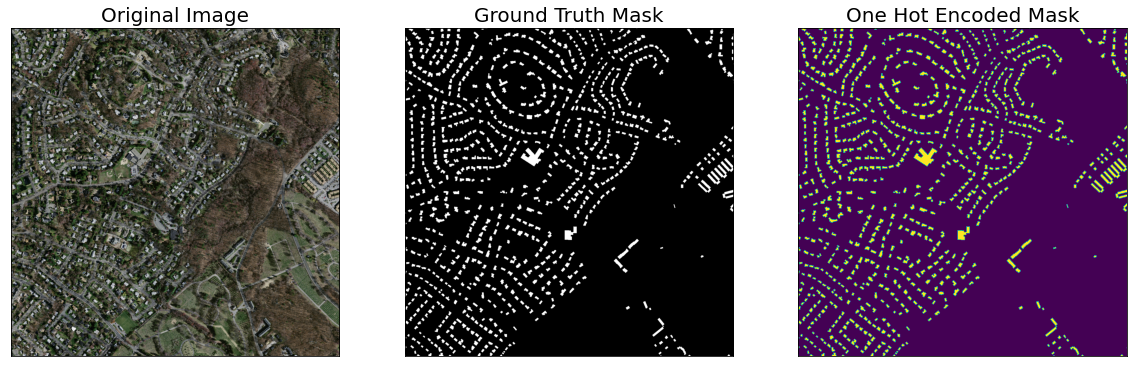

In [ ]:
dataset = ds.BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values = select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[2]

preprocess.visualize(
    original_image = image,
    ground_truth_mask = preprocess.colour_code_segmentation(preprocess.reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = preprocess.reverse_one_hot(mask)
)

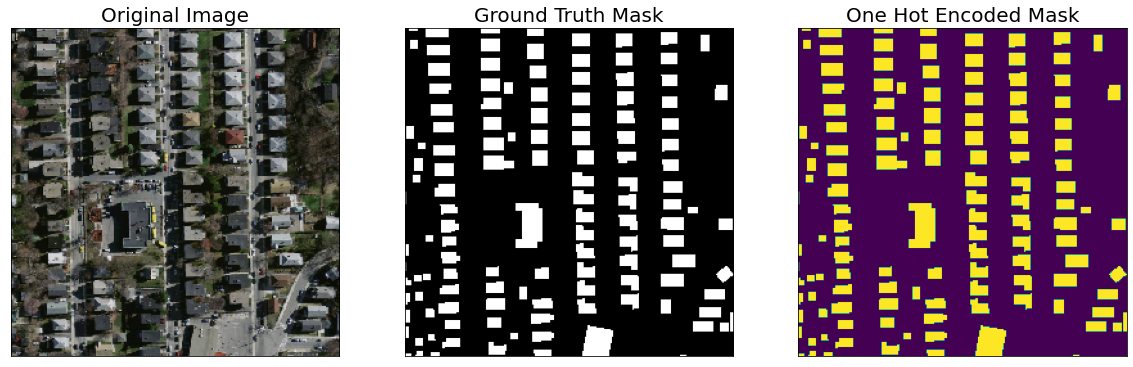

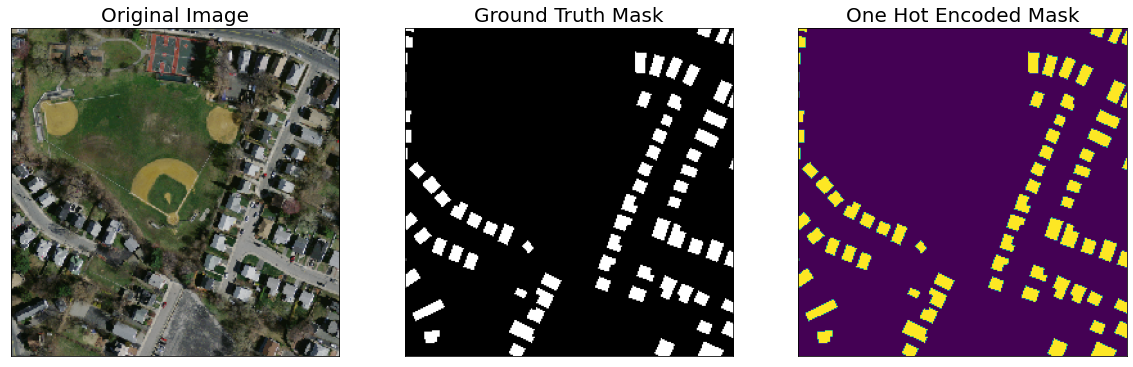

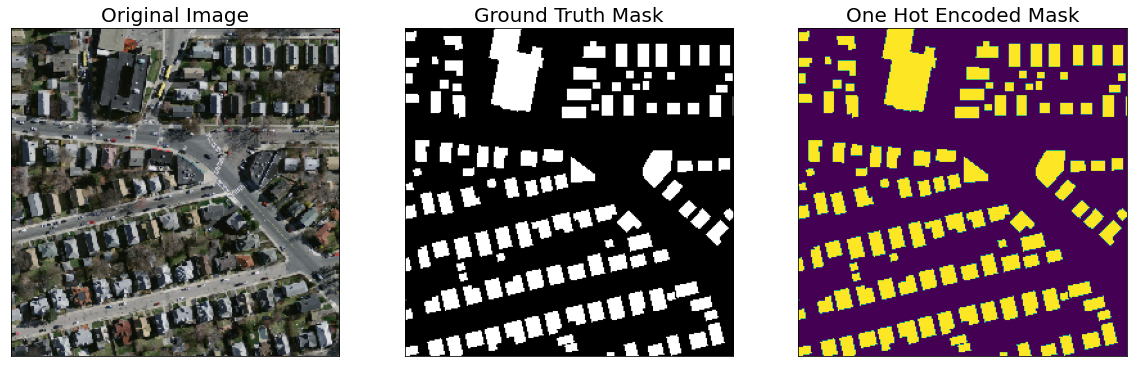

In [ ]:
augmented_dataset = ds.BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation = ds.get_training_augmentation(),
    class_rgb_values = select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset) - 1)

# Different augmentations on a random image / mask pair (256 * 256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    preprocess.visualize(
        original_image = image,
        ground_truth_mask = preprocess.colour_code_segmentation(preprocess.reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = preprocess.reverse_one_hot(mask)
    )


In [ ]:
import model_helper as model
import importlib
importlib.reload(model)
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet.initialize_basemodel(smp.Unet,len(CLASSES))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_unet.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 50

loss = lossfile.TverskyLoss(0.6,0.1)

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet.train(EPOCHS,loss,metrics,optimizer,lr,None,'tversky_loss')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.461, iou_score - 0.3287]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4432, iou_score - 0.589]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4297, iou_score - 0.6444]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4219, iou_score - 0.7191]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4213, iou_score - 0.7179]

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4154, iou_score - 0.7641]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound m

In [ ]:
import utils
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
factor_dict = utils.parse_loss_factor('/content/custom_loss1_iou.txt')

In [ ]:
factor_dict

{'bce_loss.pth': 0.32687016164724225,
 'log_cos_dice_loss.pth': 0.3346381697931814,
 'tversky_loss.pth': 0.3384916685595763}

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet.initialize_basemodel(smp.Unet,len(CLASSES))
model_unet.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 80

loss = lossfile.CustomLoss1(factor_dict['tversky_loss.pth'],factor_dict['log_cos_dice_loss.pth'],factor_dict['bce_loss.pth'])

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet.train(EPOCHS,loss,metrics,optimizer,lr,None,'custom_loss1')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.5428, iou_score - 0.1877]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4985, iou_score - 0.3714]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4295, iou_score - 0.5062]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3819, iou_score - 0.606]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3805, iou_score - 0.6662]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3649, iou_score - 0.7277]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14

In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 100

loss = lossfile.CustomLoss1(factor_dict['tversky_loss.pth'],factor_dict['log_cos_dice_loss.pth'],factor_dict['bce_loss.pth'])

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet.train(EPOCHS,loss,metrics,optimizer,lr,None,'custom_loss12')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4356, iou_score - 0.3377]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.409, iou_score - 0.4947]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.386, iou_score - 0.5839]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3616, iou_score - 0.6556]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3609, iou_score - 0.6255]

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3572, iou_score - 0.625]

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLo

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/pytho

valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2678, iou_score - 0.8341]
Model saved!

Epoch: 19
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2625, iou_score - 0.8386]
Model saved!

Epoch: 20
valid: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2613, iou_score - 0.8385]

Epoch: 21
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2644, iou_score - 0.8391]
Model saved!

Epoch: 22
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2587, iou_score - 0.8375]

Epoch: 23
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2553, iou_score - 0.8461]
Model saved!

Epoch: 24
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet.initialize_basemodel(smp.Unet,len(CLASSES))
model_unet.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 200

loss = lossfile.CustomLoss1(factor_dict['tversky_loss.pth'],factor_dict['log_cos_dice_loss.pth'],factor_dict['bce_loss.pth'])

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
##Training phase 2 loss function 2

In [ ]:
import loss as lossfile
importlib.reload(lossfile)
importlib.reload(model)

<module 'model_helper' from '/content/model_helper.py'>

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.1,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5527, iou_score - 0.653]
Model saved!

Epoch: 1
train:   0%|          | 0/9 [00:12<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(u.2,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.6341, iou_score - 0.5361]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5957, iou_score - 0.5369]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4664, iou_score - 0.6978]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4287, iou_score - 0.7469]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4118, iou_score - 0.7582]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3829, iou_score - 0.7895]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<0

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.3,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.6634, iou_score - 0.1885]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5356, iou_score - 0.4836]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4661, iou_score - 0.5808]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4125, iou_score - 0.6681]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3957, iou_score - 0.7083]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4484, iou_score - 0.7359]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<0

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.4,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.631, iou_score - 0.4057]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5502, iou_score - 0.542]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5248, iou_score - 0.5603]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4657, iou_score - 0.6315]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.45, iou_score - 0.658]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4259, iou_score - 0.7079]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:05<00:00,

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.5,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.7748, iou_score - 0.08927]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.6321, iou_score - 0.2278]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5606, iou_score - 0.3821]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5378, iou_score - 0.4618]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5117, iou_score - 0.5821]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4792, iou_score - 0.6848]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:05<

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.6,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.6782, iou_score - 0.08893]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5961, iou_score - 0.211]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5907, iou_score - 0.4339]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5093, iou_score - 0.5847]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4748, iou_score - 0.676]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.437, iou_score - 0.7415]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:05<00:

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.7,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5503, iou_score - 0.3242]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5417, iou_score - 0.3964]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4988, iou_score - 0.5086]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5223, iou_score - 0.5977]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4295, iou_score - 0.6879]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3875, iou_score - 0.7243]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:05<0

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.8,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.5178, iou_score - 0.5332]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4406, iou_score - 0.6492]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3642, iou_score - 0.7073]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3436, iou_score - 0.7074]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3094, iou_score - 0.7487]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3027, iou_score - 0.7485]

Epoch: 6
valid: 100%|██████████| 4/4 [00:05<00:00,  1.27s/

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model.train_loss2(0.9,model_unet,CLASSES,x_train_dir,y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0
valid: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.7646, iou_score - 0.1736]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.6672, iou_score - 0.3569]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4774, iou_score - 0.5529]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4292, iou_score - 0.6457]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.4007, iou_score - 0.7019]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method CustomLoss2.__name__ of CustomLoss2()> - 0.3877, iou_score - 0.7192]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<0